# Videogames online store analysis

## Project description

The Stream online store sells computer games all over the world. Historical game sales data, user and expert ratings, age ratings, genres and platforms (such as Xbox or PlayStation) are available from open sources. It is necessary to identify patterns that determine the success of the game. This will allow us to bid on a potentially popular product and plan advertising campaigns. We have data up to 2016. Let's say it's December 2016 and we're planning a campaign for 2017. First, we will study our data, process it, and then conduct research to build a portrait of the target audience. Then we will try to test some hypotheses and finally form recommendations for the formation of a campaign for the next year.

### Data import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns

Let's import our dataset:

In [2]:
df = pd.read_csv('/datasets/games.csv')

In [3]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


## Data preprocessing

### Column renaming

Let's bring the names of all columns to the lowercase form:

In [4]:
df.columns = df.columns.str.lower()
df = df.rename(columns=({'year_of_release':'release_year'}))

In [5]:
df.head()

,name,platform,release_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Data formatting

#### Dataframe info

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          16713 non-null  object 
 1   platform      16715 non-null  object 
 2   release_year  16446 non-null  float64
 3   genre         16713 non-null  object 
 4   na_sales      16715 non-null  float64
 5   eu_sales      16715 non-null  float64
 6   jp_sales      16715 non-null  float64
 7   other_sales   16715 non-null  float64
 8   critic_score  8137 non-null   float64
 9   user_score    10014 non-null  object 
 10  rating        9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Let's pay attention to `user_score`, `critic_score` and `year_of_release`. The user rating column has the `object` data type.  we will replace it with `float64` as a more relevant data type. The release year of the game should also be cast to an integer . Let's handle gaps before changing types.
<br>
Also note that the user rating is on a scale of 10, while the critic rating is on a scale of 100. This should be taken into account in further analysis.

In [7]:
# duplicates check
df.duplicated().sum()

0

No explicit duplicates found.

### Missing values and data types

Let's look at the amount of missing values in each column:

In [8]:
(
df
    .isna()
    .sum()
    .sort_values(ascending=False)
)

critic_score    8578
rating          6766
user_score      6701
release_year     269
name               2
genre              2
platform           0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
dtype: int64

The largest number of passes affects the scores and rating of games

Since there are a small number of passes with the release date of the game, name and genre, we will remove them from the dataset. Let's convert the year of release to an integer value.

In [9]:
df = df.dropna(subset=['release_year', 'name', 'genre'])
df['release_year'] = df['release_year'].astype('int')

Exclude positions with no sales in all countries:

In [10]:
df.drop(
    df[(df['jp_sales'] == 0) & 
       (df['eu_sales'] == 0) & 
       (df['na_sales'] == 0) & 
       (df['other_sales'] ==0)].index, inplace=True
)

Most of the gaps occur simultaneously in three columns. Since 6 thousand values is almost a third of our data, it will be incorrect to delete them. But there is no way to fill in such values as critics' ratings and user ratings. Therefore, we will leave gaps in these columns, but fill them with a stub. Let's examine the values of the `rating` column:

In [11]:
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [12]:
df['rating'] = df['rating'].fillna(value='N/A')

In [13]:
df['rating'].isna().sum() # check

0

ESRB rating is a game age rating system used mainly in the USA, to a lesser extent - in Europe and completely absent - in Japan. Therefore, the gaps in the rating will be due in large part to the absence of this rating system in the region. We'll also leave gaps.

Exploring data with user scores:

In [14]:
df['user_score'].value_counts().head()

tbd    2376
7.8     322
8       285
8.2     276
8.3     252
Name: user_score, dtype: int64

The abbreviation 'tbd' is quite common in user ratings, usually meaning that the rating will be determined in the future. Let's replace them with gaps:

In [15]:
df['user_score'] = df['user_score'].replace('tbd',np.nan).astype('float')

In [16]:
df[~df['user_score'].isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7463 entries, 0 to 16705
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          7463 non-null   object 
 1   platform      7463 non-null   object 
 2   release_year  7463 non-null   int64  
 3   genre         7463 non-null   object 
 4   na_sales      7463 non-null   float64
 5   eu_sales      7463 non-null   float64
 6   jp_sales      7463 non-null   float64
 7   other_sales   7463 non-null   float64
 8   critic_score  6894 non-null   float64
 9   user_score    7463 non-null   float64
 10  rating        7463 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 699.7+ KB


Thus, the dataset columns are converted to the correct data type, gaps are studied and processed.

### Total sales by region

To analyze sales, let's create a separate column with the total sales of all regions.

In [17]:
df['total_sales'] = df[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

In [18]:
df.pivot_table(index='name', values='total_sales').sort_values(by='total_sales',ascending=False).head()

,total_sales
name,
Wii Sports,82.54
Mario Kart Wii,35.52
Wii Sports Resort,32.77
Pokemon Red/Pokemon Blue,31.38
New Super Mario Bros.,29.80


Japanese games are ahead of the pack if you take the whole period of time.

### Data processing - key takeaways

We examined our dataset for duplicates, gaps and anomalous values:
- removed gaps that do not affect the course of the study;
- gaps in user ratings and critic ratings were examined and left in place since there is no way to restore these values (this also applies to not yet announced tbd ratings, which were also replaced with gaps);
- the data types were examined, after which the data type in `user_score` and `release_year` was changed to `float` and `int` respectively;
- a column with the total sales of games in all regions was created.

The main reason for the omissions could be the lack of data as such - as is the case with the ESRB ratings, which are distributed primarily in the US and not distributed in other of the regions presented. Or, for example, the not yet received user rating of some games that were marked 'tbd', which was probably entered into the system for a while and this data is supposed to be updated. Gaps in the columns of user and expert ratings could also occur due to the fact that the rating is in the process of being formed. Or at the time of the release of the game, if it was a long time ago, the formation of ratings was not a common phenomenon in the industry and gained momentum gradually with the growth of games and platforms. We also do not ignore the regional factor.
<br>
<br>
After examining the gaps by platform below, we saw that the majority of gaps in user and expert assessments are with the old Japanese platform Nintendo DS, released in 2004, and no less outdated PS and PS2.

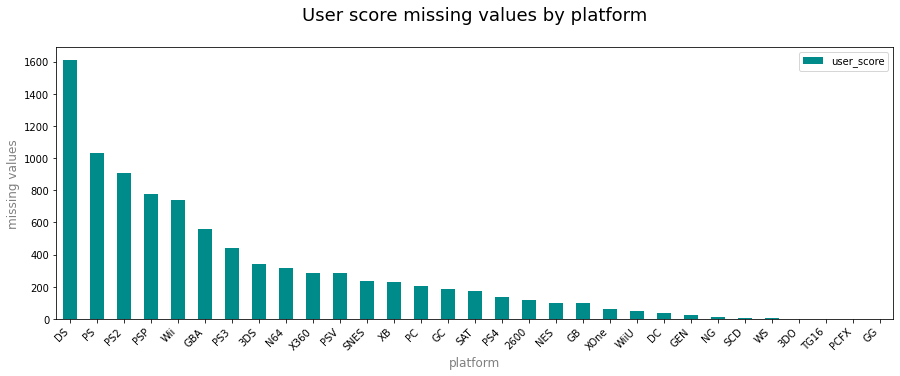

In [19]:
# user_score column gaps
na_user = df[df['user_score'].isna()].fillna(value=1)
(
na_user.pivot_table(
    index='platform', 
    values='user_score', 
    aggfunc='count')
    .sort_values(by='user_score', ascending=False)
    .plot(kind='bar',figsize=(15,5), color='darkcyan')
    .set_title('User score missing values by platform' + "\n", fontsize = 18)
)
plt.ylabel('missing values', fontsize = 12, color = 'grey')
plt.xlabel('platform', fontsize = 12, color = 'grey')
plt.xticks(rotation=45, ha='right')
plt.show()

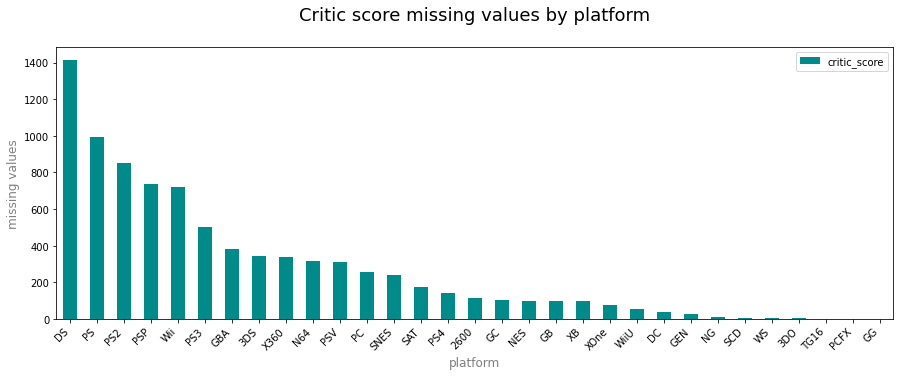

In [20]:
# critic_score missing_values
na_critic = df[df['critic_score'].isna()].fillna(value=1)

(
na_critic.pivot_table(
    index='platform', 
    values='critic_score', 
    aggfunc='count')
    .sort_values(by='critic_score', ascending=False)
    .plot(kind='bar',figsize=(15,5), color='darkcyan')
    .set_title('Critic score missing values by platform' + "\n", fontsize = 18)
)
plt.ylabel('missing values', fontsize = 12, color = 'grey')
plt.xlabel('platform', fontsize = 12, color = 'grey')
plt.xticks(rotation=45, ha='right')
plt.show()

In [21]:
# values check
temp = df.copy() 
list_c = ['name', 'platform', 'release_year', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': amount of NaN',temp[col_l].isna().sum(),
        ', % of NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16442 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          16442 non-null  object 
 1   platform      16442 non-null  object 
 2   release_year  16442 non-null  int64  
 3   genre         16442 non-null  object 
 4   na_sales      16442 non-null  float64
 5   eu_sales      16442 non-null  float64
 6   jp_sales      16442 non-null  float64
 7   other_sales   16442 non-null  float64
 8   critic_score  7983 non-null   float64
 9   user_score    7463 non-null   float64
 10  rating        16442 non-null  object 
 11  total_sales   16442 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en colores!']
name : amount of NaN 0 , % of NaN 0.0 %
---

## Exploratory data analysis

### Number of games released in different years

Let's take a closer look at the number of game releases by year.

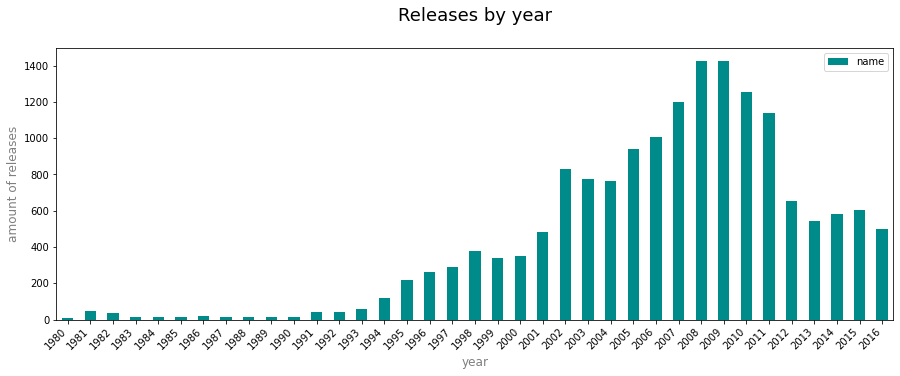

In [22]:
releases = (
df.pivot_table(
    index='release_year', 
    values='name', 
    aggfunc='count')
    .sort_values(by='release_year')
    .plot(kind='bar',figsize=(15,5), color='darkcyan')
    .set_title('Releases by year' + "\n", fontsize = 18)
)
plt.ylabel('amount of releases', fontsize = 12, color = 'grey')
plt.xlabel('year', fontsize = 12, color = 'grey')
plt.xticks(rotation=45, ha='right')
plt.show()

As it turned out, most of the games came out more than 10 years ago. The latest releases are marked in 2016. There are also releases from 20 years ago. For further analysis, they will not be so important.

### Sales dynamics by platform

Let's see which platforms are the most successful in terms of the number of sales and look at the 5 most popular ones. Let's create a pivot table and build a chart from the top 5 platforms of our dataset.

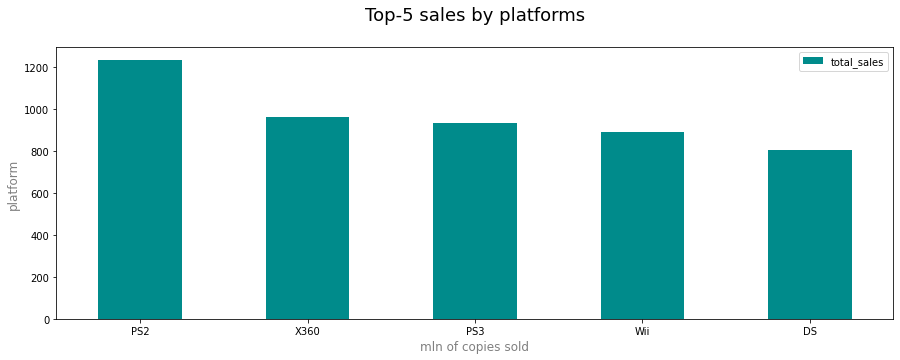

In [23]:
(
df.pivot_table(
    index='platform', 
    values='total_sales',
    aggfunc='sum')
    .sort_values(by='total_sales', ascending=False)
    .head()
    .plot(kind='bar',figsize=(15,5), color='darkcyan')
    .set_title('Top-5 sales by platforms' + "\n", fontsize = 18)
)
plt.xlabel('mln of copies sold', fontsize=12, color='grey')
plt.ylabel('platform', fontsize=12, color='grey')
plt.xticks(rotation=0)
plt.show()

The notable leader is PS2. This is probably due to the long life cycle of the console. The Xbox 360 slightly overtakes the Playsation 3 by winning that generation's race. The top did not include games of consoles of fresh generations, since their life cycle began only in 2013, so they are not being sold for that long.

Let's look at the distribution of platform sales over the past 16 years.

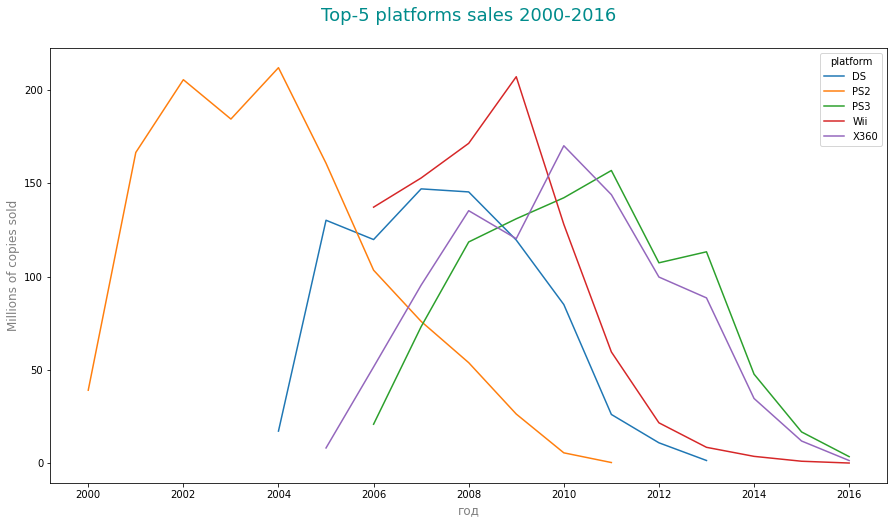

In [24]:
top_5 = df.pivot_table(
    index='platform', 
    values='total_sales', 
    aggfunc='sum').sort_values(by='total_sales').reset_index().tail()['platform']
(
df.query('platform in @top_5 and release_year >= 2000')
    .pivot_table(index='release_year', columns='platform', values='total_sales', aggfunc='sum')
    .reset_index()
    .plot(x='release_year', figsize=(15,8))
)
plt.title('Top-5 platforms sales 2000-2016' + '\n', fontsize=18, color='darkcyan')
plt.xlabel('год', fontsize=12, color='grey')
plt.ylabel('Millions of copies sold', fontsize=12, color='grey')
plt.show()

On the graph you can see the approximate life cycle of the top 5 of the platforms for 16 years. PS2 and Wii turned out to be the most tenacious. Platform sales reached their peak after 3-4 years of existence, after which there is a decline and new platforms gradually begin to replace the old ones. The latest generation consoles were not included in the data. Let's take a look at them next.

### Current period data

To understand what games will be in demand in 2017, we'll use the data from 2014-2016. This is due to the fact that for 2016 the amount of data is incomplete compared to previous years. Since 2013, new generation consoles have appeared on the market, which will primarily be replenished with new releases (as well as PCs that can be modified), so consoles released 5 or more years ago are increasingly losing their relevance.

In [25]:
# total sales of 2014
df.query('release_year == 2014')['total_sales'].sum()

331.53000000000003

In [26]:
# total sales of 2016
df.query('release_year == 2016')['total_sales'].sum()

129.94

In [27]:
# current time period dataframe
df_actual = df.query('release_year >= 2014').reset_index(drop=True)
df_actual.head()

,name,platform,release_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,N/A,14.63
1,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
2,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,N/A,11.68
3,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
4,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,N/A,7.98


### Potentially profitable platforms

Consider which platforms are potentially profitable in the current period:

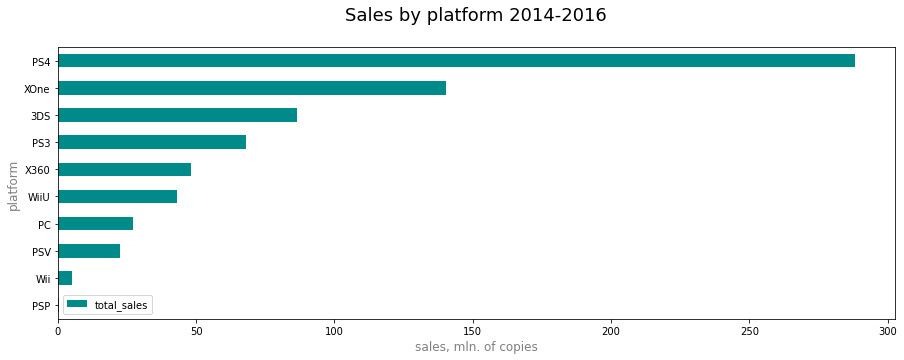

In [28]:
(
df_actual
    .pivot_table(
        index='platform', 
        values='total_sales', 
        aggfunc='sum')
    .sort_values(by='total_sales')
    .plot(kind = 'barh', figsize = (15, 5), color = 'darkcyan')
)
plt.title('Sales by platform 2014-2016' + "\n", fontsize = 18)
plt.xlabel('sales, mln. of copies', fontsize = 12, color = 'grey')
plt.ylabel('platform', fontsize = 12, color = 'grey')
plt.show()

PS4 became the bestseller of the current period. The current platforms are followed by Xbox One, Nintendo 3DS, PC and Wii U. PS Vita, Nintendo Wii and PSP have the least sales.

### Global Game Sales by Platform

Let's build boxplots to study the attractiveness of our platforms:

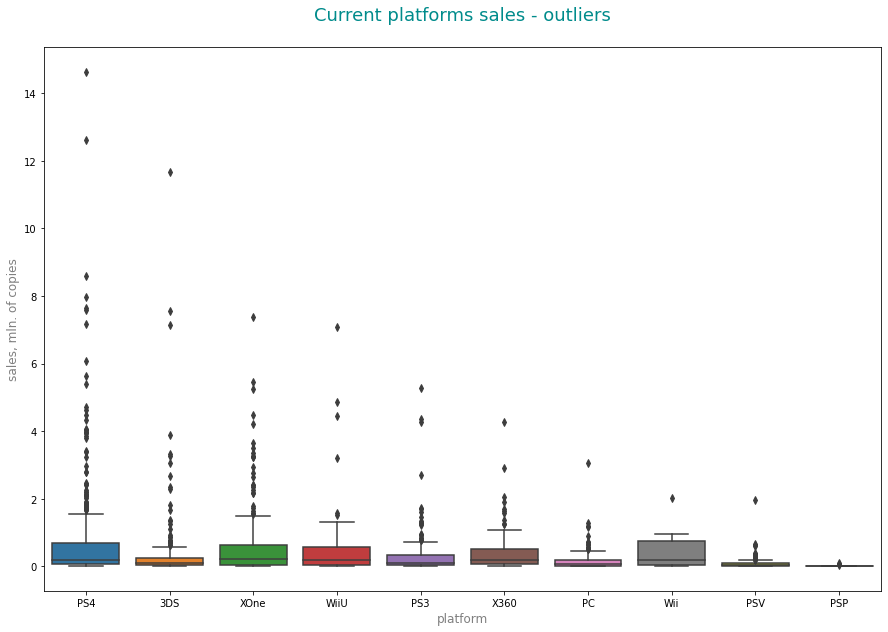

In [29]:
# data outliers
plt.figure(figsize=(15,10))
sns.boxplot(data=df_actual, x='platform', y='total_sales')
plt.title('Current platforms sales - outliers' + '\n', fontsize=18, color='darkcyan')
plt.xlabel('platform', fontsize=12, color='grey')
plt.ylabel('sales, mln. of copies', fontsize=12, color='grey')
plt.show()

PS4, 3DS, Xbox One and Wii U have the most outliers, which may indicate that there are successful titles (probably exclusive) on the platforms that outsell the rest. Similar games are much less for aging platforms and PCs.

Now let's see what the distribution by quartiles looks like, cutting off the outliers:

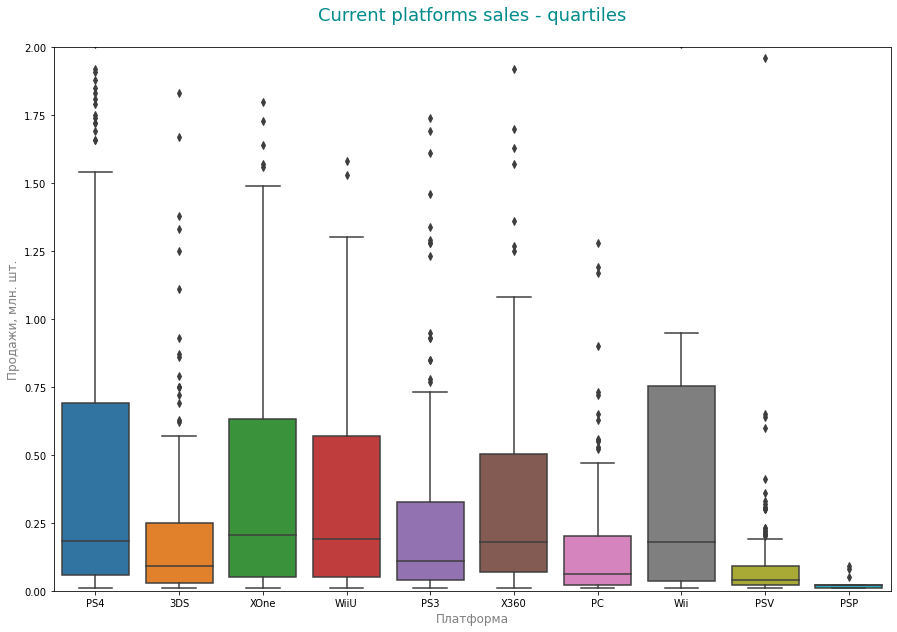

In [30]:
plt.figure(figsize=(15, 10))
(
sns.boxplot(data=df_actual, x='platform', y='total_sales')
    .set(ylim=(0,2))
)
plt.title('Current platforms sales - quartiles' + '\n', fontsize=18, color='darkcyan')
plt.xlabel('Платформа', fontsize=12, color='grey')
plt.ylabel('Продажи, млн. шт.', fontsize=12, color='grey')
plt.show()

In this case, the median values and the 75th quantile in the chart indicate that it is more profitable to sell games on PS4, Xbox One, Wii, Wii U and Xbox 360 than on 3DS, PS3, PC, PS Vita and PSP.

Thus, if stable sales of games are possible, it is most profitable to do this on PS4, Xbox One and Wii U. Wii and Xbox 360 also look attractive, but their relevance is lower than the previously mentioned consoles.
<br>
Next, let's look at how reviews affect the sales situation of the most profitable platform - PS4.

### Influence on sales within one popular platform - feedback from users and critics

The most successful last generation console in our case is the PS4. Let's consider how reviews from critics and users affect sales. Let's form scatterplots:

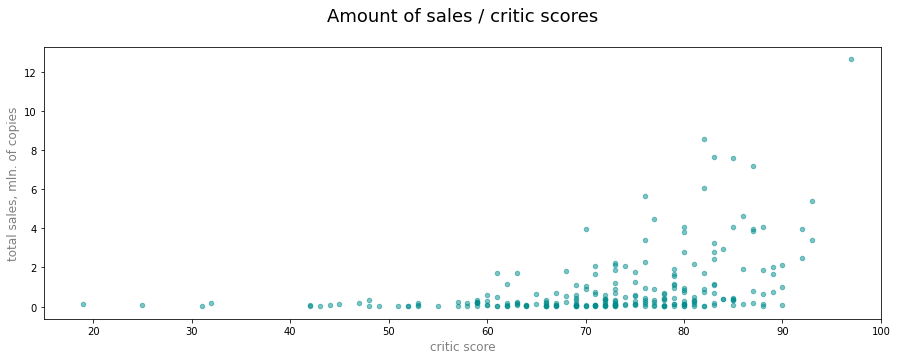

In [31]:
df_actual.query("platform == 'PS4'").plot(
    kind='scatter', 
    y='total_sales', 
    x='critic_score', 
    alpha=0.5, 
    figsize=(15,5), 
    xlim=(15,100),
    color='darkcyan')
plt.title('Amount of sales / critic scores' + '\n', fontsize=18)
plt.xlabel('critic score', fontsize=12, color='grey')
plt.ylabel('total sales, mln. of copies', fontsize=12, color='grey')
plt.show()

The opinion of critics has some influence on the number of game sales: the higher the score, the better the sales. The largest number of sold games have a score of 55 to 85 points. However, the linear correlation coefficient indicates that there is a dependence, but not strong:

In [32]:
df_actual.query("platform == 'PS4'")['critic_score'].corr(df_actual.query("platform == 'PS4'")['total_sales'])

0.40266141068104083

Let's explore how user reviews contribute to the game's sales:

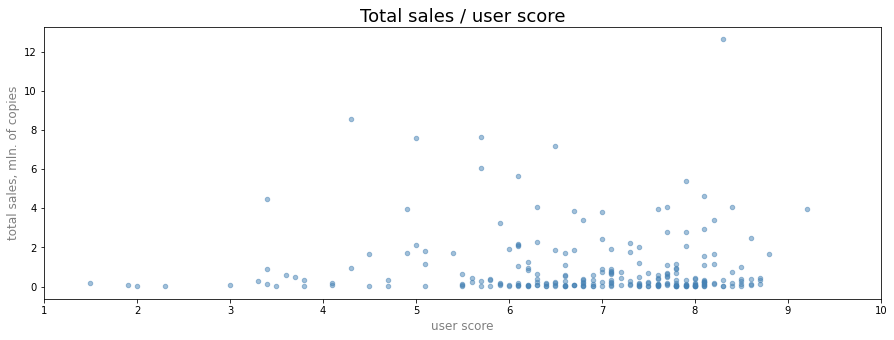

In [33]:
df_actual.query("platform == 'PS4'").plot(
    kind='scatter', 
    y='total_sales', 
    x='user_score', 
    alpha=0.5, 
    figsize=(15,5), 
    color='steelblue')
plt.title('Total sales / user score', fontsize=18)
plt.xlabel('user score', fontsize=12, color='grey')
plt.xlim(1,10)
plt.ylabel('total sales, mln. of copies', fontsize=12, color='grey')
plt.show()

User reviews do not contribute to sales growth compared to reviews from critics. We can see that the best-selling game - FIFA 16 - has sold 8.5 million copies, while having a rating of 4.3. The conclusion is confirmed by the almost zero linear correlation:

In [34]:
df_actual.query("platform == 'PS4'")['user_score'].corr(df_actual.query("platform == 'PS4'")['total_sales'])

-0.040131589472697356

In [35]:
# Top selling games with user ratings between 4 and 5
(
df_actual.query('4 < user_score < 5' )
    .sort_values(by='total_sales', ascending=False)
    .head()
    .pivot_table(index='name', values='user_score')
    .rename(columns={'user_score': 'Рейтинг'})
)

,Рейтинг
name,
Assassin's Creed: Unity,4.90
Call of Duty: Advanced Warfare,4.85
FIFA 15,4.50
FIFA 16,4.30


There is a low impact of critics' ratings on overall PS4 sales, while user ratings have almost no effect on sales. Let's look at sales on other platforms from the top 5. For example, Xbox One and PC:

3DS
critic_score    0.314117
user_score      0.215193
total_sales     1.000000
Name: total_sales, dtype: float64


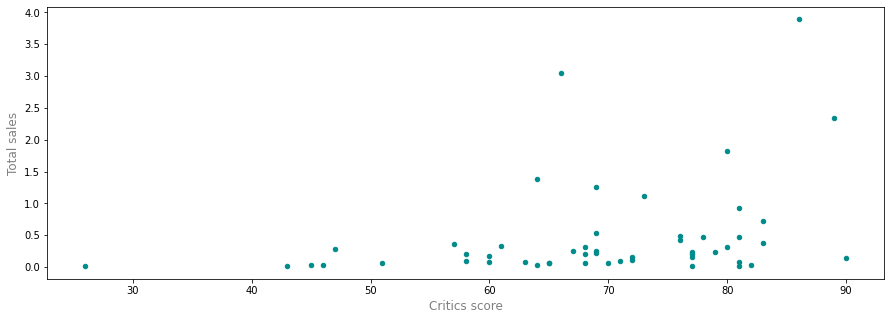

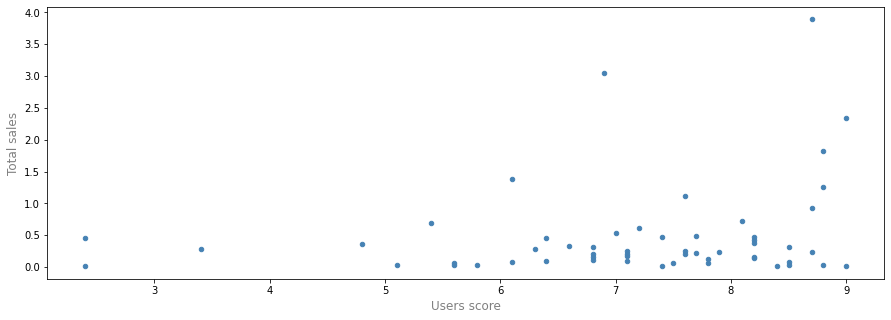

PC
critic_score    0.174634
user_score     -0.071597
total_sales     1.000000
Name: total_sales, dtype: float64


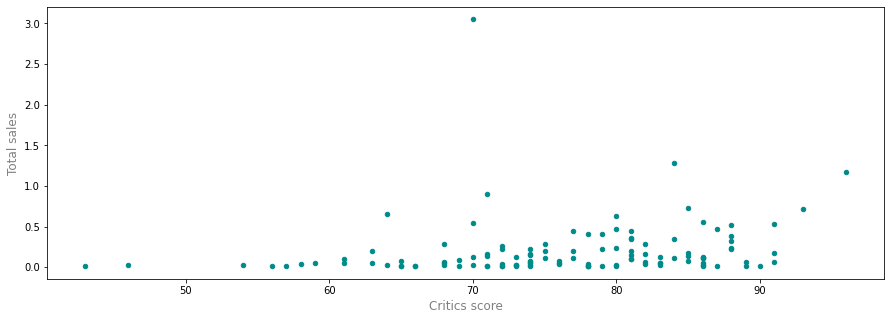

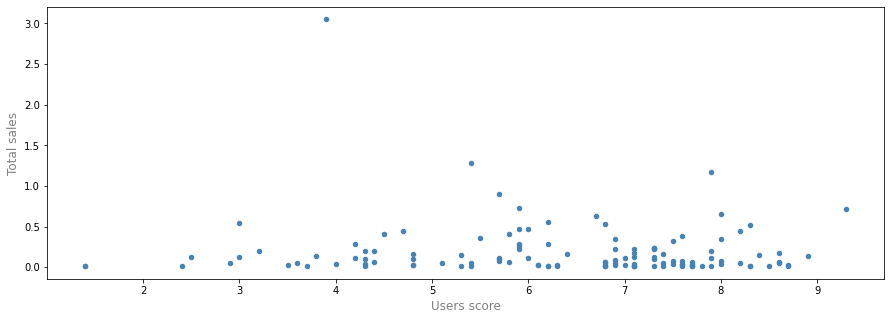

WiiU
critic_score    0.370201
user_score      0.407926
total_sales     1.000000
Name: total_sales, dtype: float64


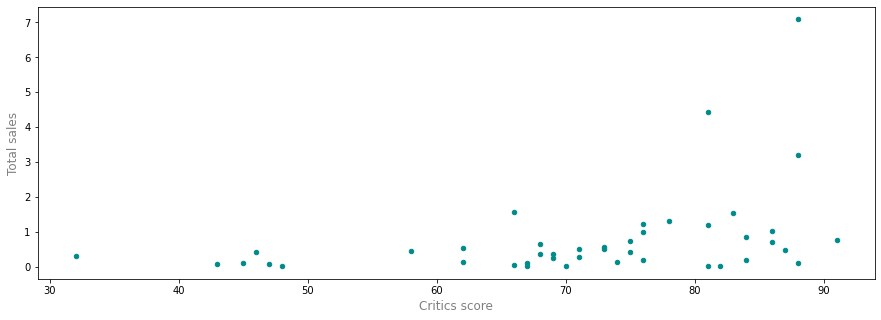

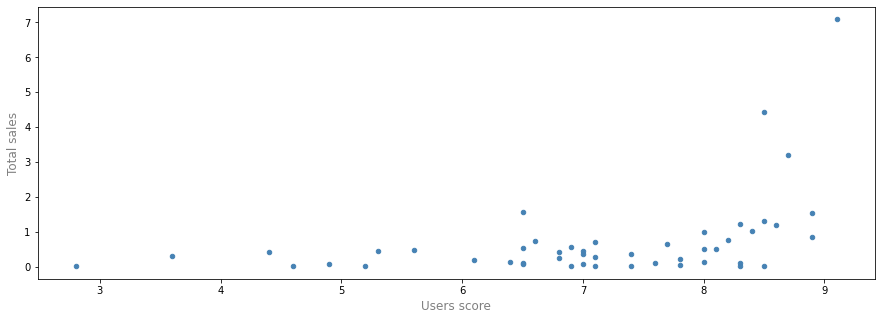

XOne
critic_score    0.428677
user_score     -0.070384
total_sales     1.000000
Name: total_sales, dtype: float64


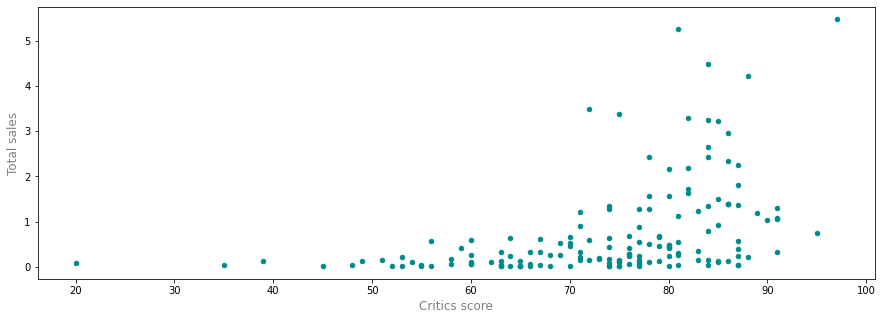

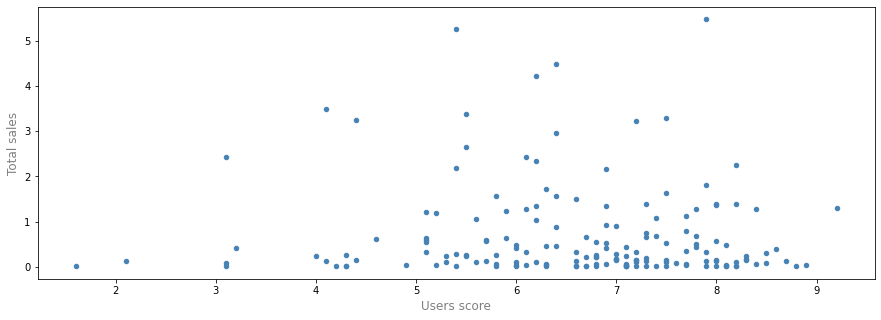

In [36]:
for platform, games in df_actual.query("platform in ['XOne', 'PC', '3DS', 'WiiU']").groupby('platform'):
    print(platform)
    print(games[['critic_score', 'user_score', 'total_sales']].corr()['total_sales'])
    games.plot(kind='scatter', x='critic_score', y='total_sales', color='darkcyan', figsize=(15,5))
    plt.xlabel('Critics score', fontsize=12, color='grey')
    plt.ylabel('Total sales', fontsize=12, color='grey')
    plt.show()
    games.plot(kind='scatter', x='user_score', y='total_sales', color='steelblue', figsize=(15,5))
    plt.xlabel('Users score', fontsize=12, color='grey')
    plt.ylabel('Total sales', fontsize=12, color='grey')
    plt.show()


We are seeing a similar situation on the Xbox One and PC platforms. But if we look at the Japanese Wii U and 3DS, the situation is slightly different - the correlation of sales with user ratings is noticeably higher there (almost on par with critics' ratings).

### Distribution of games by genre

Let's see the total amount of game sales by genre in the current period.

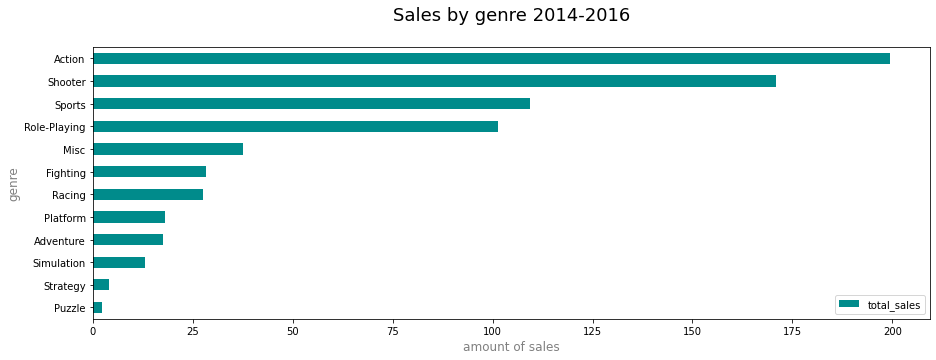

In [37]:
(
df_actual.pivot_table(index = 'genre', 
               values = 'total_sales', 
               aggfunc = 'sum')
    .sort_values(by = 'total_sales')
    .plot(kind = 'barh', 
          figsize = (15,5), 
          color = 'darkcyan')
    .set_title('Sales by genre 2014-2016' + "\n", fontsize = 18)
)
plt.xlabel('amount of sales', fontsize = 12, color = 'grey')
plt.ylabel('genre', fontsize = 12, color = 'grey')
plt.show()

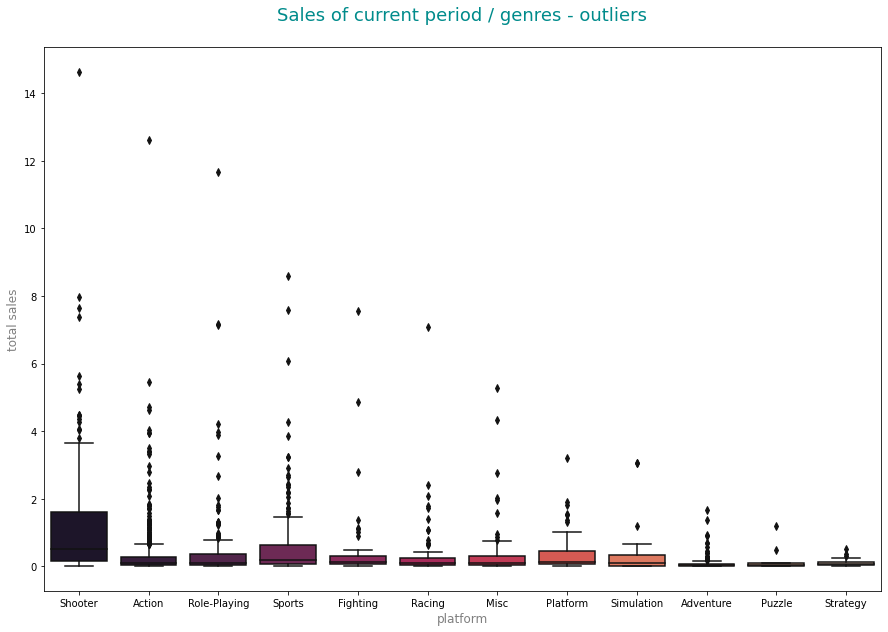

In [38]:

plt.figure(figsize=(15, 10))
(
sns.boxplot(data=df_actual, x='genre', y='total_sales', palette='rocket')
)
plt.title('Sales of current period / genres - outliers' + '\n', fontsize=18, color='darkcyan')
plt.xlabel('platform', fontsize=12, color='grey')
plt.ylabel('total sales', fontsize=12, color='grey')
plt.show()

Among shooters, action, RPG, sports, racing and adventure games, there are many successful games that bring in a lot of sales, judging by the outliers. Such games are less common in the genres of strategy, puzzles, simulators and platformers.

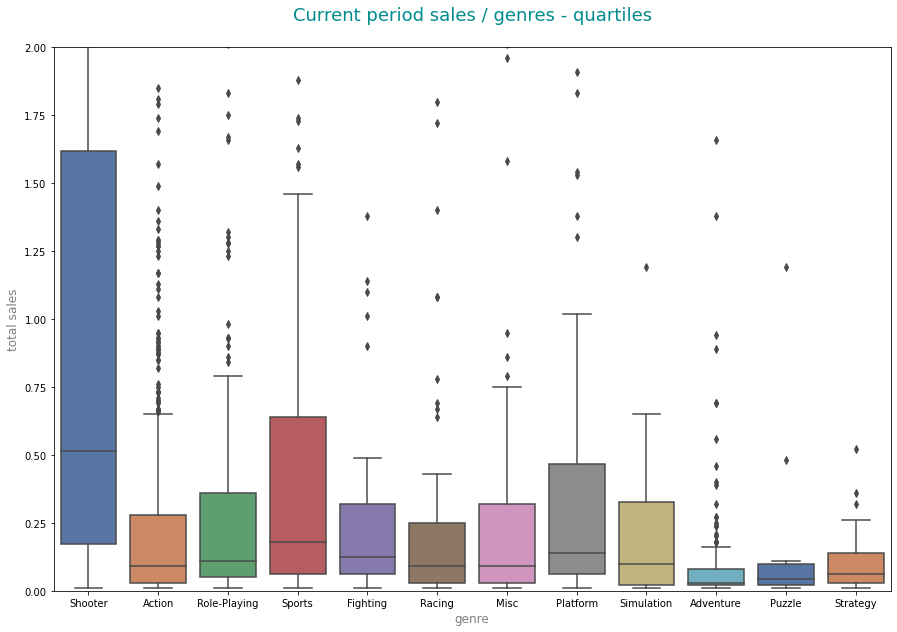

In [39]:
plt.figure(figsize=(15, 10))
(
sns.boxplot(data=df_actual, x='genre', y='total_sales', palette='deep')
        .set(ylim=(0,2))
)
plt.title('Current period sales / genres - quartiles' + '\n', fontsize=18, color='darkcyan')
plt.xlabel('genre', fontsize=12, color='grey')
plt.ylabel('total sales', fontsize=12, color='grey')
plt.show()

The medians and 75 quantiles suggest the profitability of genres such as shooters (the clear leader), sports, platformers, and RPGs. Less profitable strategies, puzzles and adventures.

The most popular genres of the current period were shooters, action, RPG, sports and platform games. Indeed, at present, game studios are willing to spend millions of dollars on the development of games in these genres. Strategies and puzzles in the current period are sold worse than others.

## User's portrait by region

Let's define for each of the regions (USA, Europe, Japan) a portrait of the target consumer of video games.

### Top 5 platforms. Differences in sales shares.

Let's study the sales of the most popular platforms depending on the region. Let's display pie charts by building a cycle, taking into account the current platforms and each region.

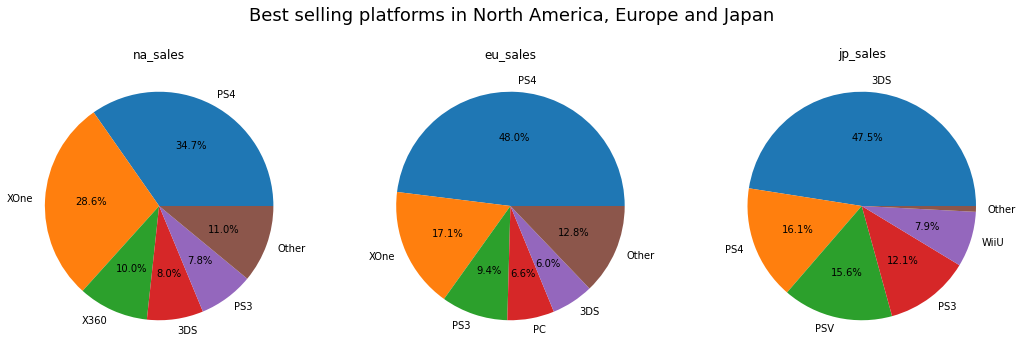

In [40]:
regions = ['na_sales', 'eu_sales', 'jp_sales']
fig, ax = plt.subplots(1, len(regions), figsize=(15,5))
for i, region in enumerate(regions):
    region_platform = (
        df_actual
        .groupby('platform')
        .agg({region:'sum'})
        .sort_values(by=region, ascending=False)
        .reset_index()
    )
    region_platform.loc[5] = ['Other', region_platform.loc[5:][region].sum().round(2)]
    region_top_platform = region_platform.head(6)        
    ax[i].pie(region_top_platform[region], labels=region_top_platform['platform'], autopct=lambda x: f'{x:.1f}%' if x > 2 else None)
    ax[i].set_title(region)
plt.suptitle('Best selling platforms in North America, Europe and Japan' + '\n', fontsize=18)
plt.tight_layout()
plt.show()

#### Platforms of North America

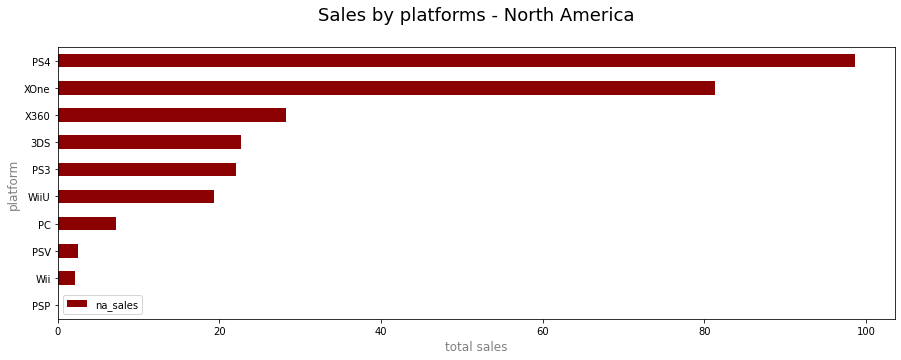

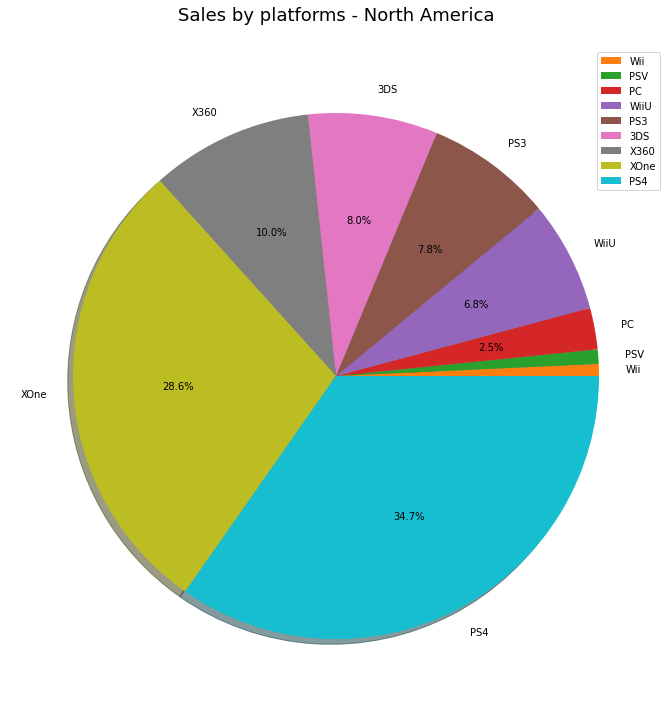

In [41]:
# building a bar chart
(
df_actual
    .pivot_table(index='platform', values='na_sales',aggfunc='sum')
    .sort_values(by='na_sales')
    .plot(kind='barh', figsize=(15,5), color='darkred')
)
plt.title('Sales by platforms - North America' + '\n', fontsize=18)
plt.xlabel('total sales', fontsize=12, color='grey')
plt.ylabel('platform', fontsize=12, color='grey')
plt.show()

# building a pie chart
(
df_actual
    .pivot_table(index='platform', values='na_sales',aggfunc='sum')
    .sort_values(by='na_sales')
    .plot(kind='pie', figsize=(15,10), subplots=True, shadow=True, autopct=lambda x: f'{x:.1f}%' if x > 2 else None)
)
plt.title('Sales by platforms - North America' + '\n', fontsize=18)
plt.ylabel(None)
plt.tight_layout()
plt.show()

For the most part, the choice of North American players in the current period is PS4 and Xbox One. This is the most lucrative market for the Xbox One, as this console is initially more focused on the American consumer with the services it provides. Next come the Xbox 360, Nintendo 3DS and PS3.

#### Platforms of Europe

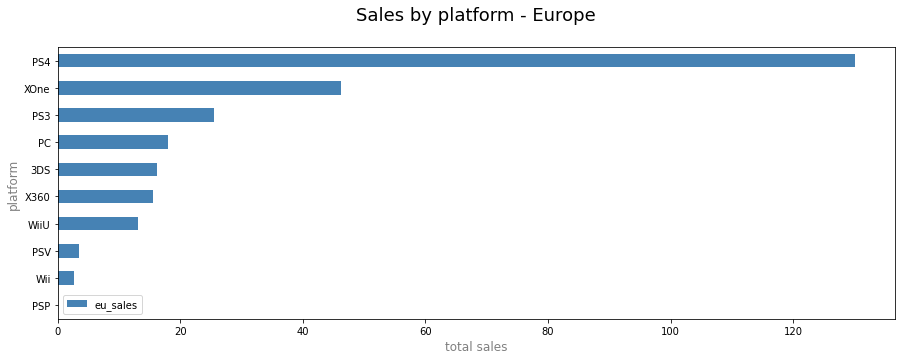

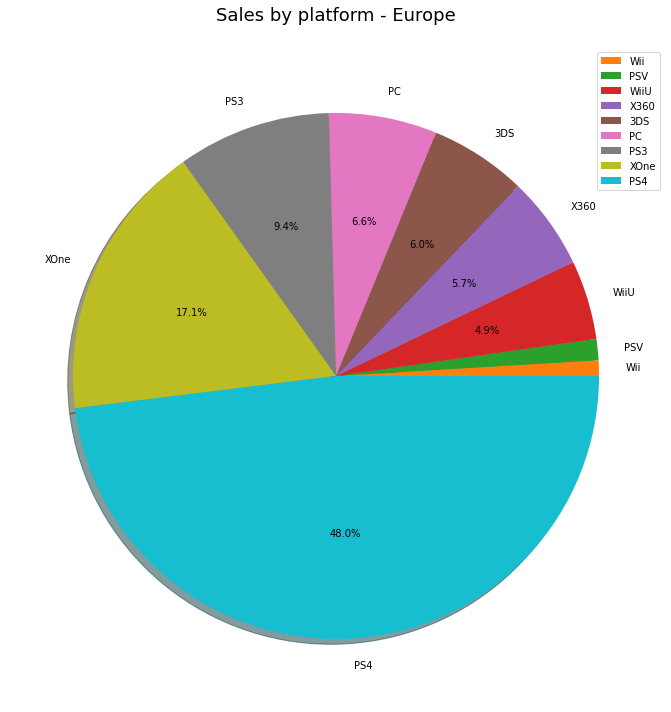

In [42]:
(
df_actual
    .pivot_table(index='platform', values='eu_sales',aggfunc='sum')
    .sort_values(by='eu_sales')
    .plot(kind='barh', figsize=(15,5), color='steelblue')
)
plt.title('Sales by platform - Europe' + '\n', fontsize=18)
plt.xlabel('total sales', fontsize=12, color='grey')
plt.ylabel('platform', fontsize=12, color='grey')
plt.show()

(
df_actual
    .pivot_table(index='platform', values='eu_sales',aggfunc='sum')
    .sort_values(by='eu_sales')
    .plot(kind='pie', figsize=(15,10), subplots=True, autopct=lambda x: f'{x:.1f}%' if x > 2 else None, shadow=True)
)
plt.title('Sales by platform - Europe' + '\n', fontsize=18)
plt.ylabel(None)
plt.tight_layout()
plt.show()

In Europe, the PS4 is the current sales leader (over 120M sales or 48%), with a significant lead over Xbox One (17% or 45M) and PS3 (9% ~ 25M). The top 5 also includes PC and 3DS.

#### Platforms of Japan

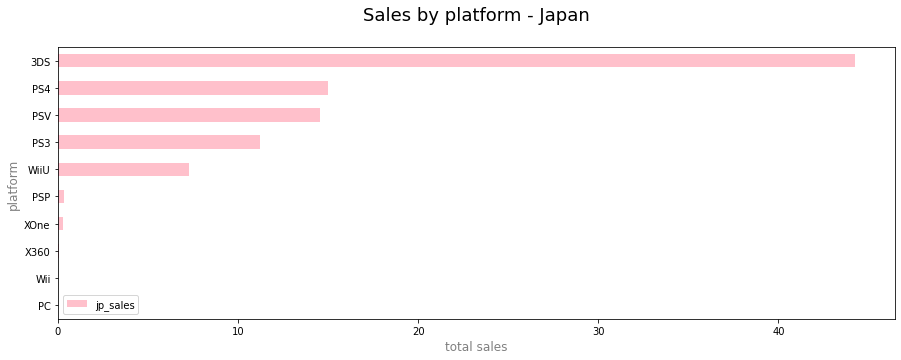

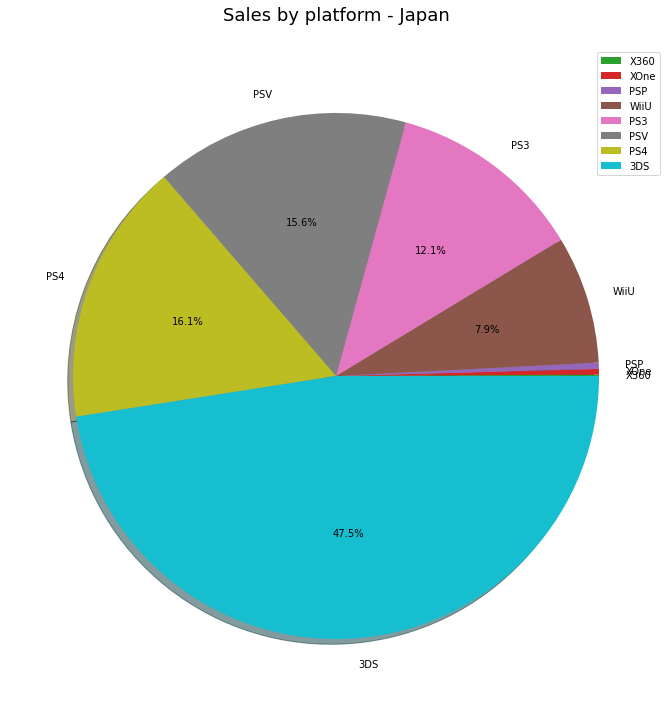

In [43]:
(
df_actual
    .pivot_table(index='platform', values='jp_sales',aggfunc='sum')
    .sort_values(by='jp_sales')
    .plot(kind='barh', figsize=(15,5), color='pink')
)
plt.title('Sales by platform - Japan' + '\n', fontsize=18)
plt.xlabel('total sales', fontsize=12, color='grey')
plt.ylabel('platform', fontsize=12, color='grey')
plt.show()

(
df_actual
    .pivot_table(index='platform', values='jp_sales',aggfunc='sum')
    .sort_values(by='jp_sales')
    .plot(kind='pie', figsize=(15,10), subplots=True, autopct=lambda x: f'{x:.1f}%' if x > 2 else None, shadow=True)
)
plt.title('Sales by platform - Japan' + '\n', fontsize=18)
plt.ylabel(None)
plt.tight_layout()
plt.show()

In Japan, the most popular - almost half of the total number of current consoles - is the Nintendo 3DS (~ 45 million sales). PS4 takes 16% of sales: Japan is the only country where Sony does not occupy a leading position in sales. Next come the PS Vita, PS3 and Wii U, respectively.

#### Key takeaways

Having studied the distribution of sales by platform in different regions, we conclude the following:
- Noticeable differences in the preferences of the players. For example, in North America, the Xbox One manages to effectively compete with the PS4, while losing noticeably to it in other regions;
- Platforms 3DS and Wii U occupy a significant share of the Japanese market, while enjoying less popularity in Europe and North America. This is natural for consoles from the Japanese Nintendo;
- The most successful platform of the current period is PS4. Its total sales exceed 100 million copies in the current period of 2014-2016, while the console sells well in every region, second only to the 3DS in Japan.

### Top 5 genres

Let's study the general distribution of the current period by the most popular genres:

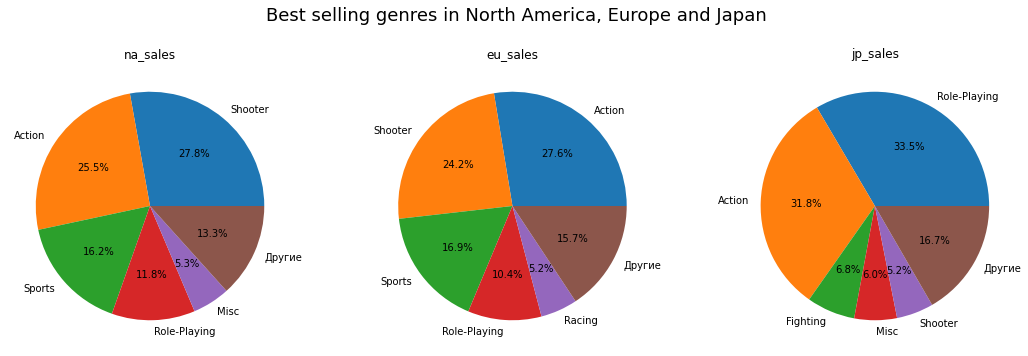

In [44]:
regions = ['na_sales', 'eu_sales', 'jp_sales']
fig, ax = plt.subplots(1, len(regions), figsize=(15,5))
for i, region in enumerate(regions):
    region_genre = (
        df_actual
        .groupby('genre')
        .agg({region:'sum'})
        .sort_values(by=region, ascending=False)
        .reset_index()
    )
    region_genre.loc[5] = ['Другие', region_genre.loc[5:][region].sum().round(2)]
    region_top_genre = region_genre.head(6)        
    ax[i].pie(region_top_genre[region], labels=region_top_genre['genre'], autopct=lambda x: f'{x:.1f}%' if x > 2 else None)
    ax[i].set_title(region)
plt.suptitle('Best selling genres in North America, Europe and Japan' + '\n', fontsize=18)
plt.tight_layout()
plt.show()

While North America and Europe are similar in their genre distribution, Japan is markedly different.

#### Genres in North America

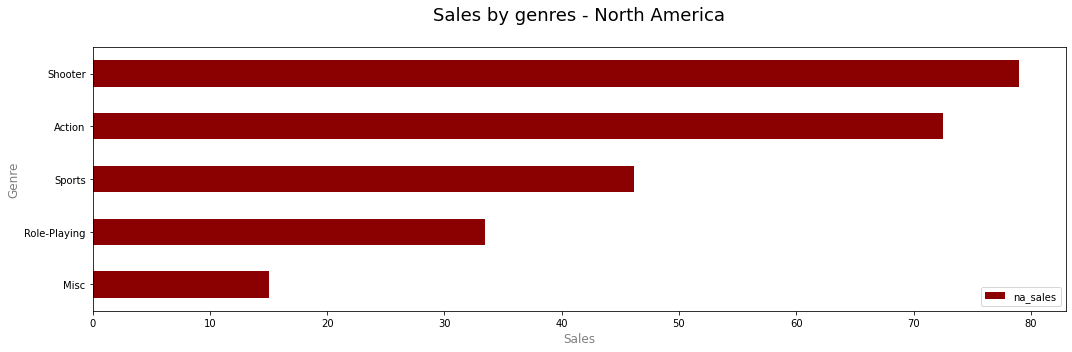

In [45]:
(
df_actual
    .pivot_table(
        index='genre', 
        values='na_sales', 
        aggfunc='sum')
    .sort_values(by='na_sales')
    .tail()
    .plot(kind = 'barh', figsize = (15, 5), color='darkred')
)
plt.title('Sales by genres - North America' + "\n", fontsize = 18)
plt.xlabel('Sales', fontsize = 12, color = 'grey')
plt.ylabel('Genre', fontsize = 12, color = 'grey')
plt.tight_layout()
plt.show()

Shooters and action - the main choice of Americans: a total of more than 120 million sales in the current period. Following are sports, role-playing and non-genre.

#### Genres in Europe

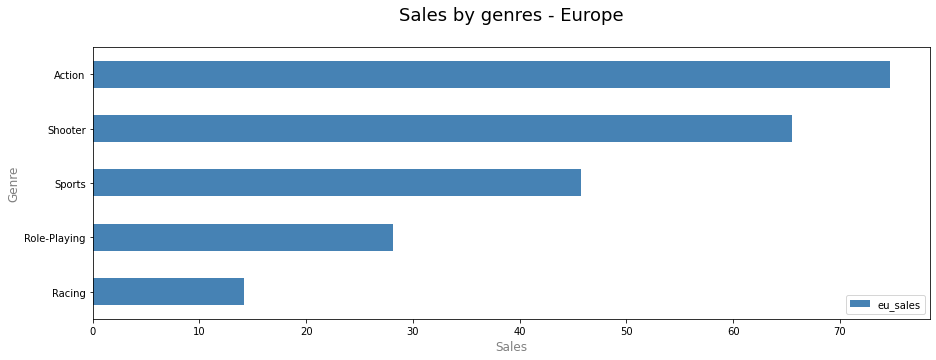

In [46]:
(
df_actual
    .pivot_table(
        index='genre', 
        values='eu_sales', 
        aggfunc='sum')
    .sort_values(by='eu_sales')
    .tail()
    .plot(kind = 'barh', figsize = (15, 5), color = 'steelblue')
)
plt.title('Sales by genres - Europe' + "\n", fontsize = 18)
plt.xlabel('Sales', fontsize = 12, color = 'grey')
plt.ylabel('Genre', fontsize = 12, color = 'grey')
plt.show()

Europeans prefer action games more than shooters, that are followed by sports and role-playing with racing genre closing the top list.

#### Genres in Japan

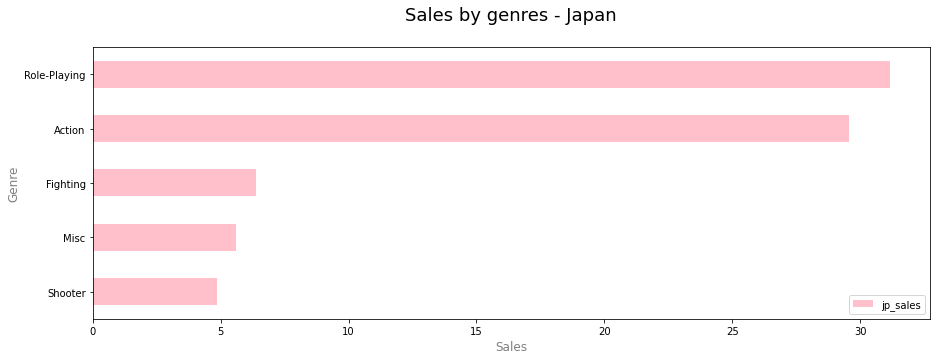

In [47]:
(
df_actual
    .pivot_table(
        index='genre', 
        values='jp_sales', 
        aggfunc='sum')
    .sort_values(by='jp_sales')
    .tail()
    .plot(kind = 'barh', figsize = (15, 5), color = 'pink')
)
plt.title('Sales by genres - Japan' + "\n", fontsize = 18)
plt.xlabel('Sales', fontsize = 12, color = 'grey')
plt.ylabel('Genre', fontsize = 12, color = 'grey')
plt.show()

The Japanese are most fond of RPG and action games. They are followed by sales of fighting games, non-genre games and shooters. It is noteworthy that shooters aren't as popular as in Europe or North America.

### ESRB rating's impact on sales

Let's examine the influence of the game's age rating on the level of its sales. Let's see what games and with what rating were sold the most.
<br>
- E: everyone (suitable for all age groups);
- E10+: everyone 10+ (from 10 years old);
- T: teen 13+ (from 13 years old);
- M: mature 17+ (from 17 years old).
<br>
Note that there are gaps in the data, since this rating is officially only available in the US and Europe. It does not apply to Japan. Nevertheless, we will study its influence according to the available data.

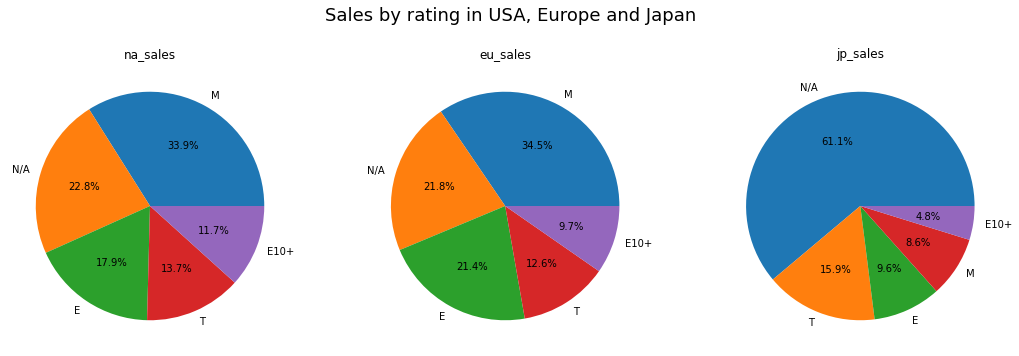

In [48]:
# list of regions
regions = ['na_sales', 'eu_sales', 'jp_sales']
# creating a loop for displaying diagrams
fig, ax = plt.subplots(1, len(regions), figsize=(15,5))
for i, region in enumerate(regions):
    region_rating = (
        df_actual
        .groupby('rating')
        .agg({region:'sum'})
        .sort_values(by=region, ascending=False)
        .reset_index()
    )
    region_top_rating = region_rating.head(6)        
    ax[i].pie(region_top_rating[region], labels=region_top_rating['rating'], autopct='%1.1f%%')
    ax[i].set_title(region)
plt.suptitle('Sales by rating in USA, Europe and Japan' + '\n', fontsize=18)
plt.tight_layout()
plt.show()

The largest number of games sold during the current period in North America and Europe have an age rating of 17+ and are aimed at an adult audience. Further, we see that more than 20% of the rating in America and Europe and more than 60% in Japan are missing. Earlier we found out that ESRB is officially presented only in the USA and Canada.

#### Rating impact on sales - North America

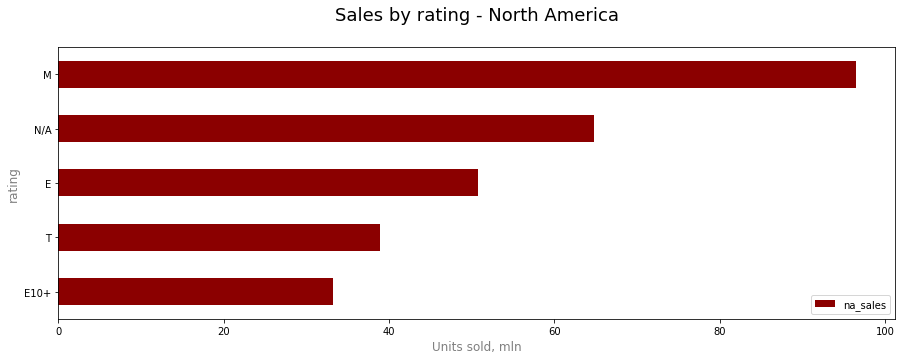

In [49]:
(
df_actual.pivot_table(index = 'rating', 
               values = 'na_sales', 
               aggfunc = 'sum')
    .sort_values(by = 'na_sales')
    .plot(kind = 'barh', 
          figsize = (15,5), 
          color = 'darkred')
)
plt.title('Sales by rating - North America' + "\n", fontsize = 18)
plt.xlabel('Units sold, mln', fontsize = 12, color = 'grey')
plt.ylabel('rating', fontsize = 12, color = 'grey')
plt.show()

In North America, most games are sold to an adult audience - from 17 years old and games with an absent rating. The lowest number of sales in the current period for games with a limit of 10 + and 13+

#### Rating impact on sales - Europe

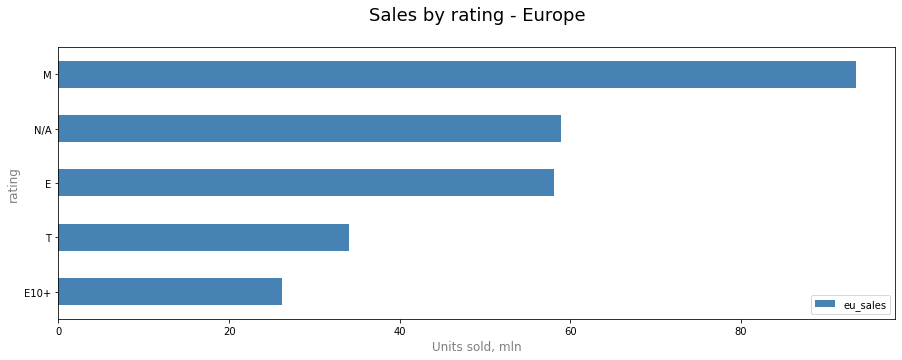

In [50]:
(
df_actual.pivot_table(index = 'rating', 
               values = 'eu_sales', 
               aggfunc = 'sum')
    .sort_values(by = 'eu_sales')
    .plot(kind = 'barh', 
          figsize = (15,5), 
          color = 'steelblue')
)
plt.title('Sales by rating - Europe' + "\n", fontsize = 18)
plt.xlabel('Units sold, mln', fontsize = 12, color = 'grey')
plt.ylabel('rating', fontsize = 12, color = 'grey')
plt.show()

In Europe, there is a similar pattern to North America. There are a lot of games without a certain age rating.

#### Rating impact on sales - Japan

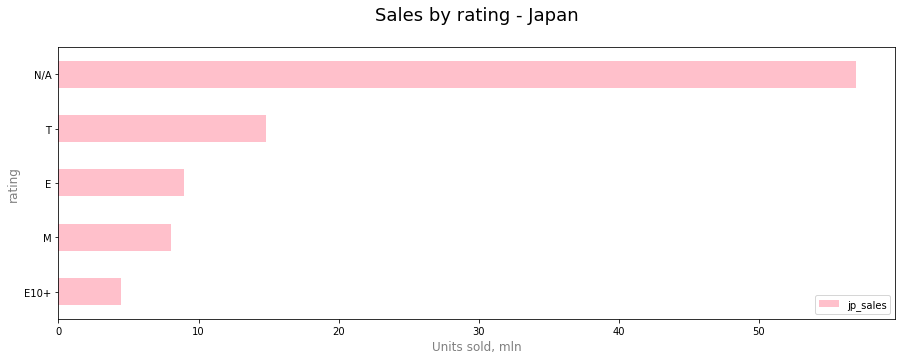

In [51]:
(
df_actual.pivot_table(index = 'rating', 
               values = 'jp_sales', 
               aggfunc = 'sum')
    .sort_values(by = 'jp_sales')
    .plot(kind = 'barh', 
          figsize = (15,5), 
          color = 'pink')
)
plt.title('Sales by rating - Japan' + "\n", fontsize = 18)
plt.xlabel('Units sold, mln', fontsize = 12, color = 'grey')
plt.ylabel('rating', fontsize = 12, color = 'grey')
plt.show()

In Japan, the largest part of the data on the ESRB age rating is missing. The country has its own rating system - CERO (Computer Entertainment Rating Organization). According to the few available data, it is possible to note sales in children's and teen genres, probably provided by consoles from Nintendo. However, it is difficult to draw a conclusion about the age distribution of games in this case - there is little data.

### Conclusion - the impact of the rating on sales in the regions and the portrait of the target audience

Considering the above, we conclude that the share of sales by age rating in Europe and North America is similar. Due to the absence of an ESRB rating in Japan as such, the largest part of the data is not available and it is difficult to unambiguously conclude about the share of sales of games of a particular age group.
Therefore we can see some behavioral patterns:
- Users from North America mainly prefer to play shooters and action games with a rating of 17+, using platforms such as PS4 and Xbox One - consoles that exceed 180 million copies in sales in the current period;
- Europeans are similar in preferences to the North American market, more often choosing action games and the PS4 platform. The total sales of these genres at the same time amounted to approximately 120 million copies;
- In Japan, RPG and action games are more often chosen, the most popular platform is Nintendo 3DS. Since there is not enough data on the age rating of games, it is problematic to draw an unambiguous conclusion about the age rating according to our data. However, given that the main target audience of the most popular 3DS console are children and teenagers, let's assume that games with a similar rating are selling well.

## Hypothesis testing

Let's consider hypotheses: first - user ratings for Xbox One and PC, then similarly for the action and sports genre. In the first case, the null hypothesis will be the statement that the average ratings are equal, in the second - different. In our case, we will use the Welch t-test `test_ind`, since the hypothesis of the equality of the two sample averages is being tested. We also doubt that the variances of the samples are the same by specifying the parameter `equal_var = False`

### Hypothesis 1: the average user ratings of the Xbox One and PC platforms are the same

The null hypothesis in our case will be: the average user ratings of the Xbox One and PC platforms are the same. Alternative hypothesis: the average user ratings of the Xbox One and PC platforms are different. For comparison, let's take the previously sorted data for 2014-2016 `df_actual`, since the Xbox One, unlike the PC, appeared on the market only at the end of 2013 and it would be incorrect to take a longer period.

In [52]:
xbox = df_actual[(df_actual['platform'] == 'XOne') & (df_actual['user_score'] > 0)]['user_score']
pc = df_actual[(df_actual['platform'] == 'PC') & (df_actual['user_score'] > 0)]['user_score']
results = st.ttest_ind(xbox, pc, equal_var=False)
alpha = .05

print('p-value:', results.pvalue) 
if results.pvalue < alpha:
    print('reject the null hypothesis')
else:
    print('We do not reject the null hypothesis')

p-value: 0.11601398086668832
We do not reject the null hypothesis


In [53]:
df_actual.query("platform == ['XOne', 'PC']").pivot_table(index='platform', values='user_score', aggfunc='mean')

,user_score
platform,
PC,6.298361
XOne,6.594545


Since our p-value is higher than the alpha threshold, we do not reject the hypothesis of equality of averages between user ratings. 11.6% is too high a probability to make a conclusion about the difference in user ratings.

### Hypothesis 2: The average user ratings of the Action and Sports genres are different.


Null hypothesis we take the statement that the average user ratings of the action and sports genres are equal. An alternative hypothesis would be the opposite situation, in which the average ratings of these genres are different.

In [54]:
action = df_actual[(df_actual['genre'] == 'Action') & (df_actual['user_score'] > 0)]['user_score']
sports = df_actual[(df_actual['genre'] == 'Sports') & (df_actual['user_score'] > 0)]['user_score']
results = st.ttest_ind(action, sports, equal_var=False)

alpha = .05

print('p-value:', results.pvalue) 
if results.pvalue < alpha:
    print('reject the null hypothesis')
else:
    print('We do not reject the null hypothesis')

p-value: 1.1825550382644557e-14
reject the null hypothesis


In [55]:
df_actual.query("genre == ['Action', 'Sports']").pivot_table(index='genre', values='user_score', aggfunc='mean')

,user_score
genre,
Action,6.760606
Sports,5.225197


Thus, we reject the hypothesis that the average user ratings of genres are equal.

## Final conclusion

A study of the sales of the online game store "Streamchik" was conducted. Historical sales data was provided, including user and expert ratings, genres and platforms. For the correct conduct of the study, we performed the following steps:
- data preparation: got rid of outliers where possible and added the necessary values;
- research analysis: we studied sales by year and platform, determined the current period for the campaign for the next year and studied sales in it;
- portrait of the user of each region: determined the preferences of users in each of the regions by platforms, genres and rating;
- tested hypotheses about the equality and difference of the two averages: we conducted a t-test by creating the necessary arrays and using the method to compare the equality of the two averages `ttest_ind`.

In summary, action games and shooters released on PS4 and Xbox One with an M (17+) rating will become a potentially popular product in 2017 for the North American and European markets. RPG and action games released on 3DS and suitable for all ages will be a good solution for Japan.